In [40]:
%pylab inline
import os
import mrcfile
import numpy as np
import cupy as cp
import pandas as pd
from tqdm.notebook import tqdm

sys.path.append('/SIFT_gs/')
from SIFT_gs.FIBSEM_SIFT_gs import *

Populating the interactive namespace from numpy and matplotlib
Open CV version:  4.5.3


In [33]:
def correlation_coefficient(frame1, frame2):
    product = np.mean((frame1 - frame1.mean()) * (frame2 - frame2.mean()))
    stds = frame1.std() * frame2.std()
    if stds == 0:
        return 0
    else:
        product /= stds
        return product

def read_transformation_matrix_from_xf_file(fn):
    npdt_recalled = pd.read_csv(fn, sep = '  ', header = None)
    tr = npdt_recalled.to_numpy()
    transformation_matrix = np.zeros((len(tr), 3, 3))
    transformation_matrix[:, 0, 0:2] = tr[:,0:2]
    transformation_matrix[:, 0, 2] = tr[:,6]
    transformation_matrix[:, 1, 0:2] = tr[:,2:4]
    transformation_matrix[:, 1, 2] = tr[:,9]
    transformation_matrix[:, 2, 2] = np.ones((len(tr)))   
    return transformation_matrix

def analyze_transformation_matrix(transformation_matrix, fn):
    Xshift_orig = transformation_matrix[:, 0, 2]
    Yshift_orig = transformation_matrix[:, 1, 2]
    Xscale_orig = transformation_matrix[:, 0, 0]
    Yscale_orig = transformation_matrix[:, 1, 1]
    tr_matr_cum = transformation_matrix.copy()

    prev_mt = np.eye(3,3)
    for j, cur_mt in enumerate(tqdm(transformation_matrix, desc='Calculating Cummilative Transformation Matrix')):
        if any(np.isnan(cur_mt)):
            print('Frame: {:d} has ill-defined transformation matrix, will use identity transformation instead:'.format(j))
            print(cur_mt)
        else:
            prev_mt = np.matmul(cur_mt, prev_mt)
        tr_matr_cum[j] = prev_mt
    # Now insert identity matrix for the zero frame which does not need to be trasformed
    tr_matr_cum_orig = tr_matr_cum.copy()

    s00_cum_orig = tr_matr_cum[:, 0, 0].copy()
    s11_cum_orig = tr_matr_cum[:, 1, 1].copy()
    s01_cum_orig = tr_matr_cum[:, 0, 1].copy()
    s10_cum_orig = tr_matr_cum[:, 1, 0].copy()
    
    Xshift_cum_orig = tr_matr_cum_orig[:, 0, 2]
    Yshift_cum_orig = tr_matr_cum_orig[:, 1, 2]


    #print('Recalculating Shifts')
    s00_cum_orig = tr_matr_cum[:, 0, 0]
    s11_cum_orig = tr_matr_cum[:, 1, 1]
    fr = np.arange(0, len(s00_cum_orig), dtype=float)
    s00_slp = -1.0 * (np.sum(fr)-np.dot(s00_cum_orig,fr))/np.dot(fr,fr) # find the slope of a linear fit with fiorced first scale=1
    s00_fit = 1.0 + s00_slp * fr
    s00_cum_new = s00_cum_orig + 1.0 - s00_fit
    s11_slp = -1.0 * (np.sum(fr)-np.dot(s11_cum_orig,fr))/np.dot(fr,fr) # find the slope of a linear fit with fiorced first scale=1
    s11_fit = 1.0 + s11_slp * fr
    s11_cum_new = s11_cum_orig + 1.0 - s11_fit
    
    s01_slp = np.dot(s01_cum_orig,fr)/np.dot(fr,fr) # find the slope of a linear fit with forced first scale=1
    s01_fit = s01_slp * fr
    s01_cum_new = s01_cum_orig - s01_fit
    s10_slp = np.dot(s10_cum_orig,fr)/np.dot(fr,fr) # find the slope of a linear fit with forced first scale=1
    s10_fit = s10_slp * fr
    s10_cum_new = s10_cum_orig - s10_fit

    Xshift_cum = tr_matr_cum[:, 0, 2]
    Yshift_cum = tr_matr_cum[:, 1, 2]

    subtract_linear_fit=True

    # Subtract linear trend from offsets
    if subtract_linear_fit:
        fr = np.arange(0, len(Xshift_cum) )
        pX = np.polyfit(fr, Xshift_cum, 1)
        Xfit = np.polyval(pX, fr)
        pY = np.polyfit(fr, Yshift_cum, 1)
        Yfit = np.polyval(pY, fr)
        Xshift_residual = Xshift_cum - Xfit
        Yshift_residual = Yshift_cum - Yfit
    else:
        Xshift_residual = Xshift_cum.copy()
        Yshift_residual = Yshift_cum.copy()

    # define new cum. transformation matrix where the offests may have linear slopes subtracted
    tr_matr_cum_residual = tr_matr_cum.copy()
    tr_matr_cum_residual[:, 0, 2] = Xshift_residual
    tr_matr_cum_residual[:, 1, 2] = Yshift_residual
    tr_matr_cum_residual[:, 0, 0] = s00_cum_new
    tr_matr_cum_residual[:, 1, 1] = s11_cum_new
    tr_matr_cum_residual[:, 0, 1] = s01_cum_new
    tr_matr_cum_residual[:, 1, 0] = s10_cum_new

    fs = 12
    fig5, axs5 = subplots(3,3, figsize=(18, 12), sharex=True)
    fig5.subplots_adjust(left=0.15, bottom=0.08, right=0.99, top=0.94)

    # plot scales
    axs5[0, 0].plot(Xscale_orig, 'r', label = 'Sxx fr.-to-fr.')
    axs5[0, 0].plot(Yscale_orig, 'b', label = 'Syy fr.-to-fr.')
    axs5[0, 0].set_title('Frame-to-Frame Scale Change', fontsize = fs + 1)
    axs5[1, 0].plot(tr_matr_cum_orig[:, 0, 0], 'r', linestyle='dotted', label = 'Sxx cum.')
    axs5[1, 0].plot(tr_matr_cum_orig[:, 1, 1], 'b', linestyle='dotted', label = 'Syy cum.')
    axs5[1, 0].plot(s00_fit, 'r', label = 'Sxx cum. - lin. fit')
    axs5[1, 0].plot(s11_fit, 'b', label = 'Syy cum. - lin. fit')
    axs5[1, 0].set_title('Cumulative Scale', fontsize = fs + 1)
    axs5[2, 0].plot(tr_matr_cum_residual[:, 0, 0], 'r', label = 'Sxx cum. - residual')
    axs5[2, 0].plot(tr_matr_cum_residual[:, 1, 1], 'b', label = 'Syy cum. - residual')
    axs5[2, 0].set_title('Residual Cumulative Scale', fontsize = fs + 1)
    axs5[2, 0].set_xlabel('Frame', fontsize = fs + 1)
    
    # plot shears
    axs5[0, 1].plot(transformation_matrix[:, 0, 1], 'r', label = 'Sxy fr.-to-fr.')
    axs5[0, 1].plot(transformation_matrix[:, 1, 0], 'b', label = 'Syx fr.-to-fr.')
    axs5[0, 1].set_title('Frame-to-Frame Shear', fontsize = fs + 1)
    axs5[1, 1].plot(tr_matr_cum_orig[:, 0, 1], 'r', linestyle='dotted', label = 'Sxy cum.')
    axs5[1, 1].plot(tr_matr_cum_orig[:, 1, 0], 'b', linestyle='dotted', label = 'Syx cum.')
    axs5[1, 1].plot(s01_fit, 'r', label = 'Sxy cum. - lin. fit')
    axs5[1, 1].plot(s10_fit, 'b', label = 'Syx cum. - lin. fit')
    axs5[1, 1].set_title('Cumulative Shear', fontsize = fs + 1)
    axs5[2, 1].plot(tr_matr_cum_residual[:, 0, 1], 'r', label = 'Sxy cum. - residual')
    axs5[2, 1].plot(tr_matr_cum_residual[:, 1, 0], 'b', label = 'Syx cum. - residual')
    axs5[2, 1].set_title('Residual Cumulative Shear', fontsize = fs + 1)
    axs5[2, 1].set_xlabel('Frame', fontsize = fs + 1)

    # plot shifts
    axs5[0, 2].plot(Xshift_orig, 'r', label = 'Tx fr.-to-fr.')
    axs5[0, 2].plot(Yshift_orig, 'b', label = 'Ty fr.-to-fr.')
    axs5[0, 2].set_title('Frame-to-Frame Shift', fontsize = fs + 1)
    axs5[1, 2].plot(Xshift_cum, 'r', linestyle='dotted', label = 'Tx cum.')
    axs5[1, 2].plot(Xfit, 'r', label = 'Tx cum. - lin. fit')
    axs5[1, 2].plot(Yshift_cum, 'b', linestyle='dotted', label = 'Ty cum.')
    axs5[1, 2].plot(Yfit, 'b', label = 'Ty cum. - lin. fit')
    axs5[1, 2].set_title('Cumulative Shift', fontsize = fs + 1)
    axs5[2, 2].plot(tr_matr_cum_residual[:, 0, 2], 'r', label = 'Tx cum. - residual')
    axs5[2, 2].plot(tr_matr_cum_residual[:, 1, 2], 'b', label = 'Ty cum. - residual')
    axs5[2, 2].set_title('Residual Cumulative Shift', fontsize = fs + 1)
    axs5[2, 2].set_xlabel('Frame', fontsize = fs + 1)

    for ax in axs5.ravel():
        ax.grid(True)
        ax.legend()
    fig5.suptitle(fn, fontsize = fs + 2)
    fig5.savefig(fn +'_Transform_Summary.png', dpi=300)
    return tr_matr_cum

C:\tools\miniconda3\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


Calculating Cummilative Transformation Matrix:   0%|          | 0/4379 [00:00<?, ?it/s]

Frame: 1401 has ill-defined transformation matrix, will use identity transformation instead:
[[ 1.0001806e+00 -5.3810000e-04            nan]
 [ 8.2300000e-05  1.0016274e+00            nan]
 [ 0.0000000e+00  0.0000000e+00  1.0000000e+00]]
Frame: 1402 has ill-defined transformation matrix, will use identity transformation instead:
[[ 9.999068e-01  6.040000e-04  9.480000e+00]
 [-9.800000e-06  9.989209e-01           nan]
 [ 0.000000e+00  0.000000e+00  1.000000e+00]]
Frame: 3652 has ill-defined transformation matrix, will use identity transformation instead:
[[ 1.0000299e+00 -4.8601000e-03 -9.4530000e+00]
 [ 2.2960000e-04  9.8606490e-01            nan]
 [ 0.0000000e+00  0.0000000e+00  1.0000000e+00]]
Frame: 3721 has ill-defined transformation matrix, will use identity transformation instead:
[[ 1.0001308e+00 -2.1273000e-03            nan]
 [ 1.4400000e-05  1.0003293e+00            nan]
 [ 0.0000000e+00  0.0000000e+00  1.0000000e+00]]


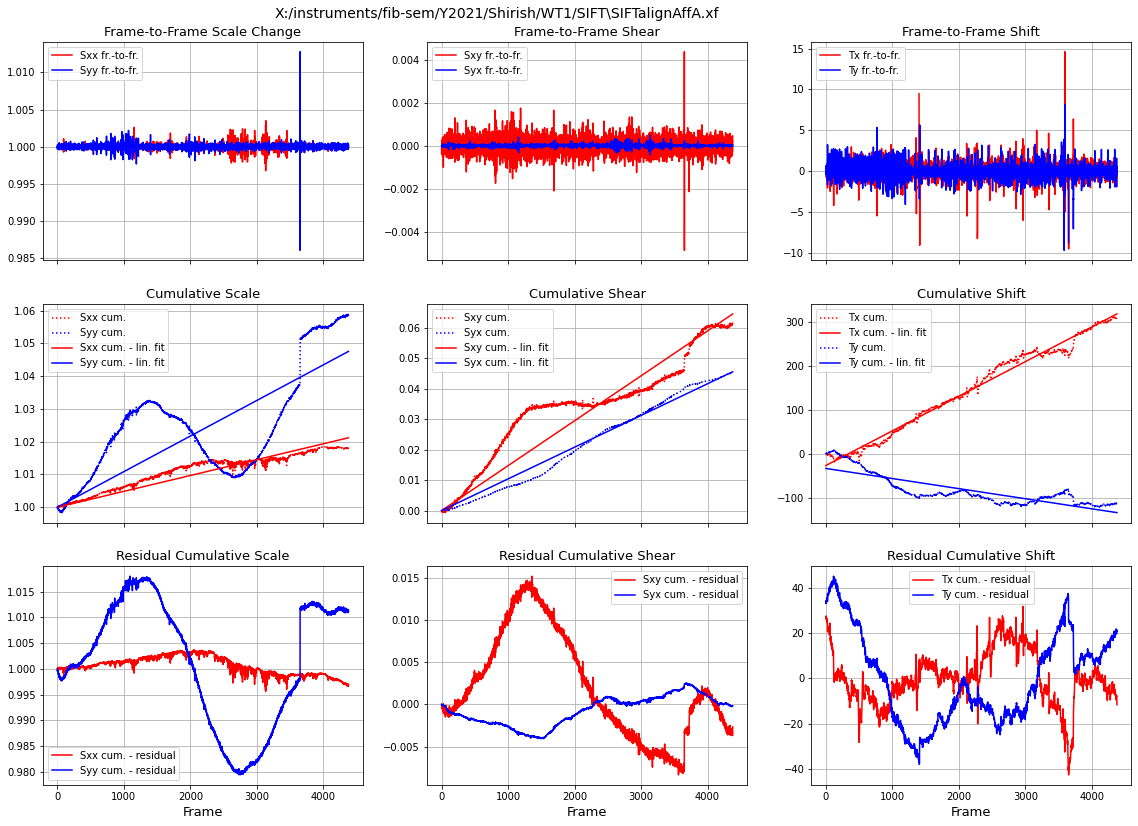

In [34]:
data_dir = 'Z:/FIB-SEM SIFT align code/Test data'
data_dir = 'Z:/FIB-SEM SIFT align code/Test data 2 from J10'
data_dir = 'X:/instruments/fib-sem/Y2021/Shirish/WT1/SIFT'
transf_file = 'SIFTalignAffA.xf'
fn = os.path.join(data_dir, transf_file)

transformation_matrix_aff = read_transformation_matrix_from_xf_file(fn)
tt = analyze_transformation_matrix(transformation_matrix_aff, fn)

C:\tools\miniconda3\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


Calculating Cummilative Transformation Matrix:   0%|          | 0/4379 [00:00<?, ?it/s]

Frame: 1401 has ill-defined transformation matrix, will use identity transformation instead:
[[ 1. -0. nan]
 [-0.  1. nan]
 [ 0.  0.  1.]]
Frame: 1402 has ill-defined transformation matrix, will use identity transformation instead:
[[ 1.    -0.     9.515]
 [-0.     1.       nan]
 [ 0.     0.     1.   ]]
Frame: 3652 has ill-defined transformation matrix, will use identity transformation instead:
[[ 1. -0. nan]
 [-0.  1. nan]
 [ 0.  0.  1.]]
Frame: 3721 has ill-defined transformation matrix, will use identity transformation instead:
[[ 1. -0. nan]
 [-0.  1. nan]
 [ 0.  0.  1.]]


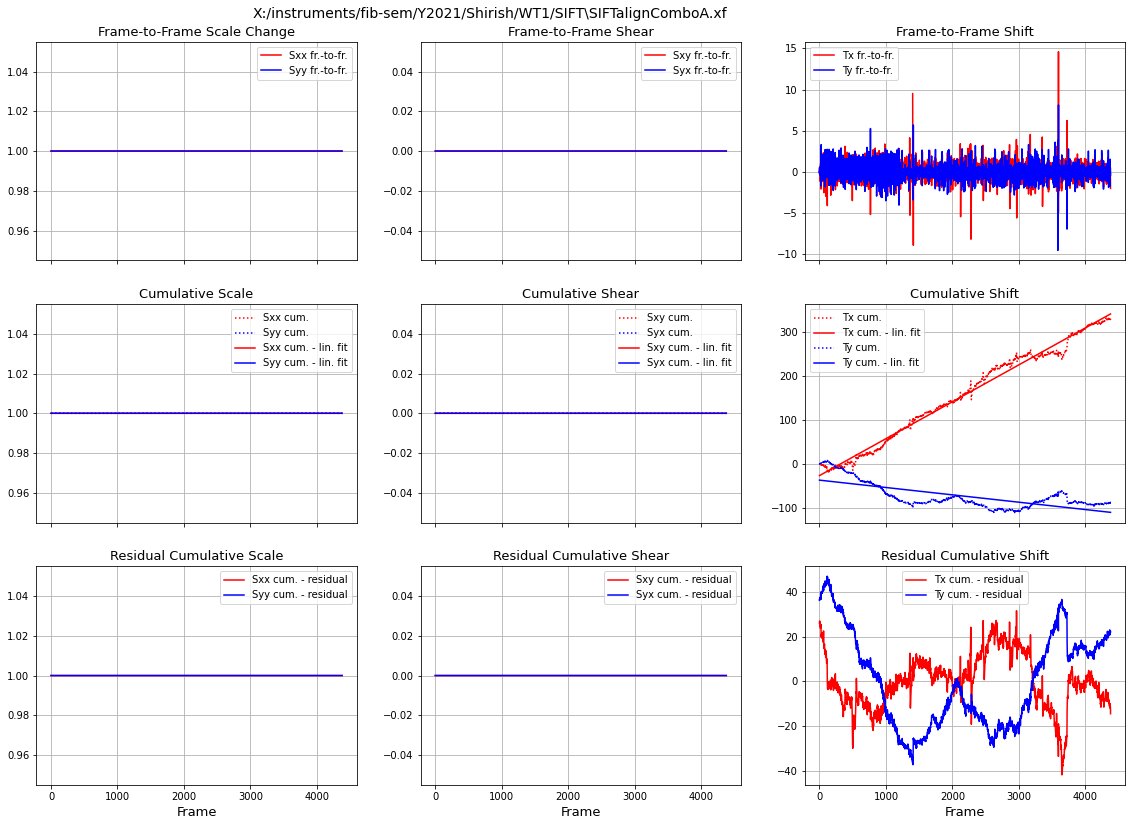

In [35]:
data_dir = 'X:/instruments/fib-sem/Y2021/Shirish/WT1/SIFT'
transf_file = 'SIFTalignComboA.xf'
fn = os.path.join(data_dir, transf_file)

transformation_matrix_aff = read_transformation_matrix_from_xf_file(fn)
tt = analyze_transformation_matrix(transformation_matrix_aff, fn)

In [48]:
lwl=1
fs=12
nmi = [np.mean(image_mi), np.median(image_mi), np.std(image_mi)]

Processing the data file  X:/instruments/fib-sem/Y2021/Shirish/WT1/mrc\rawstack-imgA.mrc


Evaluating frame registration:   0%|          | 0/4378 [00:00<?, ?it/s]

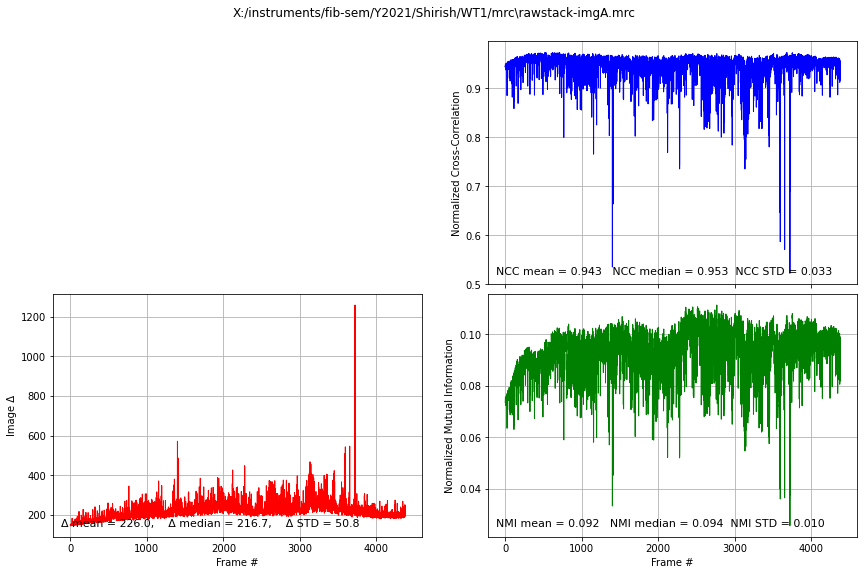

In [52]:
data_dir = 'X:/instruments/fib-sem/Y2021/Shirish/WT1/mrc'
files = ['SIFTalignCombo-imgA.mrc',
        'rawstack-imgA.mrc']

lwl=1
fs=12

for mrc_stack in files:
    fmrc = os.path.join(data_dir, mrc_stack)
    padx1 = 100
    pady1 = 100

    mrc = mrcfile.mmap(fmrc, mode='r+')
    header = mrc.header
    nx, ny, nz = int32(header['nx']), int32(header['ny']), int32(header['nz'])

    image_diff = np.zeros((nz-1), dtype=float)
    image_ncc = np.zeros((nz-1), dtype=float)
    image_mi = np.zeros((nz-1), dtype=float) 

    prev_frame = mrc.data[0, pady1:-pady1, padx1:-padx1].astype(float)
    frames = np.arange(nz-1)+1
    print('Processing the data file ', fmrc)
    for j in tqdm(frames, desc='Evaluating frame registration: '):
        curr_frame = mrc.data[j, pady1:-pady1, padx1:-padx1].astype(float)
        I1c = cp.array(curr_frame)
        I2c = cp.array(prev_frame)
        image_diff[j-1] =  cp.asnumpy(cp.mean(cp.abs(I1c-I2c)))
        image_ncc[j-1] = correlation_coefficient(prev_frame, curr_frame)
        image_mi[j-1] = cp.asnumpy(mutual_information_2d_cp(I1c.ravel(), I2c.ravel(), sigma=1.0, bin=2048, normalized=True))
        del I1c, I2c
        prev_frame = curr_frame.copy()
    mrc.close()

    imd = [np.mean(image_diff), np.median(image_diff), np.std(image_diff)] 
    nccs = [np.mean(image_ncc), np.median(image_ncc), np.std(image_ncc)]
    nmi = [np.mean(image_mi), np.median(image_mi), np.std(image_mi)]
    
    fig4, axs4 = subplots(2,2, figsize=(12, 8), sharex=True)
    fig4.subplots_adjust(left=0.06, bottom=0.06, right=0.99, top=0.92, wspace=0.18, hspace=0.04)

    #axs4[0,0].plot(error_abs_mean, 'magenta', linewidth=lwl)
    #axs4[0,0].text(0.02, 0.12, cond_str, transform=axs4[0,0].transAxes)
    #axs4[0,0].text(0.02, 0.04, 'Mean Abs Error= {:.3f}   Median Abs Error= {:.3f}'.format(np.mean(error_abs_mean), np.median(error_abs_mean)), transform=axs4[0,0].transAxes, fontsize = fs-1)
    #axs4[0,0].set_ylabel('Mean Abs. Error (KeyPts)')
    axs4[0,0].axis(False)

    axs4[1,0].plot(image_diff, 'r', linewidth=lwl)
    axs4[1,0].set_ylabel('Image Δ')
    #axs4[1,0].text(0.02, 0.12, cond_str, transform=axs4[0,1].transAxes)
    axs4[1,0].text(0.02, 0.04, 'Δ mean = {:.1f},    Δ median = {:.1f},    Δ STD = {:.1f}'.format(imd[0], imd[1], imd[2]), transform=axs4[1,0].transAxes, fontsize = fs-1)
    axs4[1,0].set_xlabel('Frame #')

    axs4[0,1].plot(image_ncc, 'b', linewidth=lwl)
    axs4[0,1].set_ylabel('Normalized Cross-Correlation')
    axs4[0,1].grid(True)
    #axs4[0,1].legend(loc='upper left')
    #axs4[0,1].text(0.02, 0.12, cond_str, transform=axs4[1,0].transAxes)
    axs4[0,1].text(0.02, 0.04, 'NCC mean = {:.3f}   NCC median = {:.3f}  NCC STD = {:.3f}'.format(nccs[0], nccs[1], nccs[2]), transform=axs4[0,1].transAxes, fontsize = fs-1)

    axs4[1,1].plot(image_mi, 'g', linewidth=lwl)
    axs4[1,1].set_ylabel('Normalized Mutual Information')
    axs4[1,1].set_xlabel('Frame #')
    axs4[1,1].grid(True)
    #axs4[1,1].legend(loc='upper left')
    #axs4[1,1].text(0.02, 0.12, cond_str, transform=axs4[1,1].transAxes)
    axs4[1,1].text(0.02, 0.04, 'NMI mean = {:.3f}   NMI median = {:.3f}  NMI STD = {:.3f}'.format(nmi[0], nmi[1], nmi[2]), transform=axs4[1,1].transAxes, fontsize = fs-1)

    for ax in axs4.ravel():
        ax.grid(True)
        #ax.legend(loc='upper left')

    ld = len(fmrc)
    ldm = 100
    fmrc_short = fmrc if ld<ldm else '... '+fmrc[-ldm:]     
    fig4.suptitle(fmrc_short, fontsize=fs)
    fig4.savefig(fmrc.replace('.mrc','_RegistrationQuality.png'), dpi=300)
    
    registration_summary_fnm = fmrc.replace('.mrc', '_RegistrationQuality.csv')
    columns=['Image Delta', 'Image NCC', 'Image MI']
    reg_summary = pd.DataFrame(np.vstack((image_diff, image_ncc, image_mi)).T, columns = columns, index = None)
    reg_summary.to_csv(registration_summary_fnm, index = None)